In [1]:
ls

'Foof demand.ipynb'           meal_info.csv      time.csv
 fulfilment_center_info.csv   test_QoiMO9B.csv   train.csv


In [1]:
# Importing libraries
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
#import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error


In [2]:
train = pd.read_csv('time.csv')

In [3]:
train['Datetime'] = pd.to_datetime(train['Datetime'])
train['year'] = train['Datetime'].dt.year
train['month'] = train['Datetime'].dt.month
train['day'] = train['Datetime'].dt.dayofyear
train['weekday'] = train['Datetime'].dt.weekday
train['hour'] = train['Datetime'].dt.hour

In [5]:
train['Datetime'].dt

In [27]:
train.head()
del train['ID']

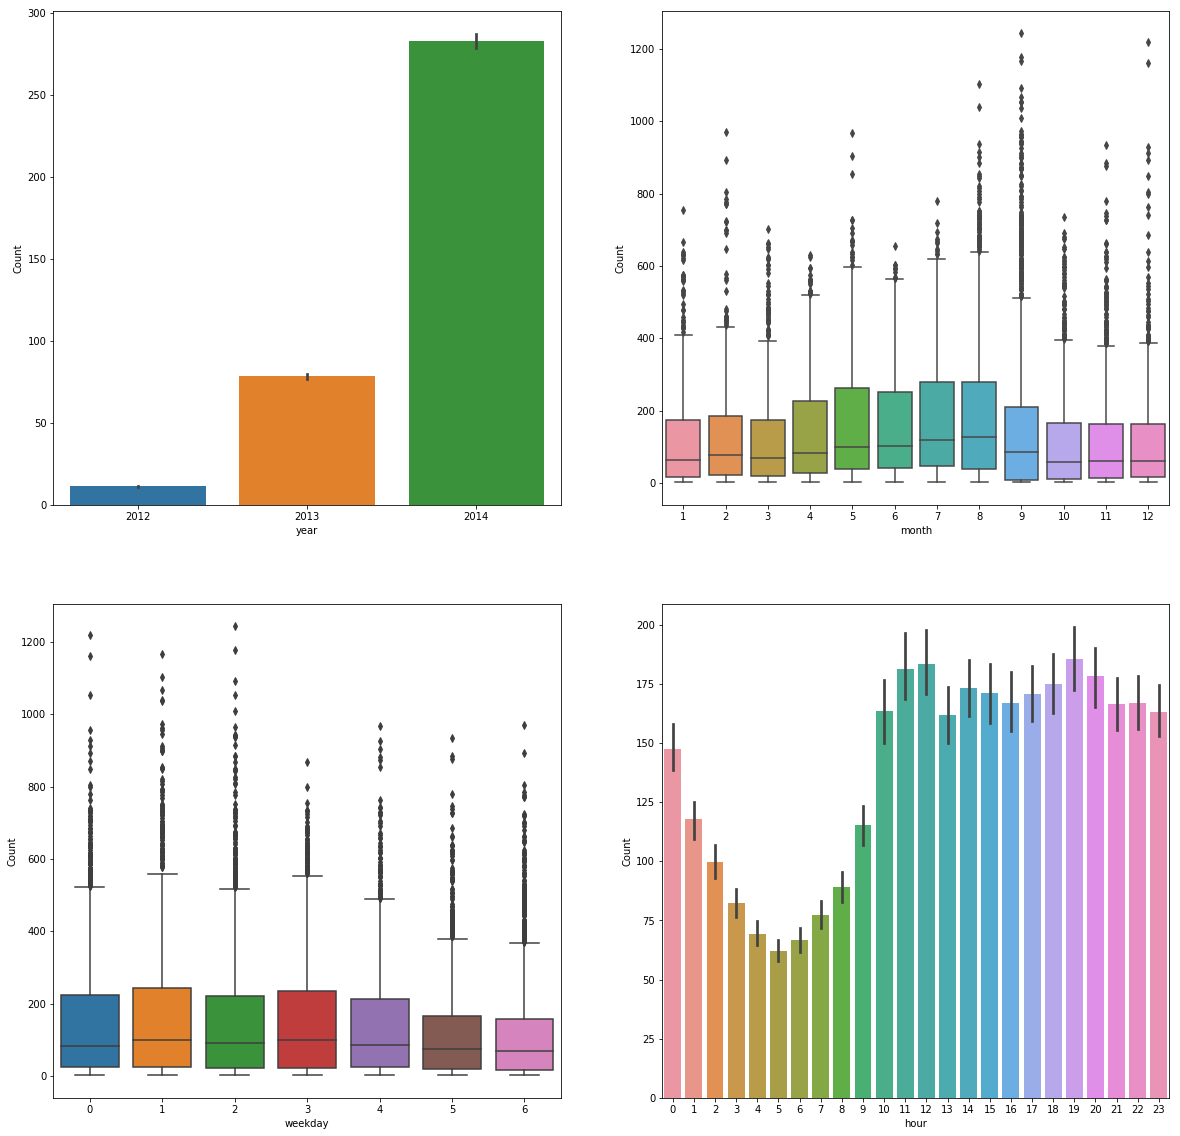

In [28]:
f, axes = plt.subplots(2,2)
f.set_size_inches(20,20)

sns.barplot(y="Count", x= "year", data=train,  orient='v' , ax=axes[0,0],)
sns.boxplot(y="Count", x= "month", data=train,  orient='v' , ax=axes[0,1])
sns.boxplot(y = 'Count', x='weekday', data = train, orient = 'v' , ax = axes[1,0])
sns.barplot(y="Count", x= "hour", data=train,  orient='v' , ax=axes[1,1],)

# Inferences
## Most of the data is provided of year 2014
## There is some trend according to months 1,2 and 11,12 having somewhat lower values
## Days of week 5,6 also have comparitevly lower values
## Most clear pattern is observed in hours 

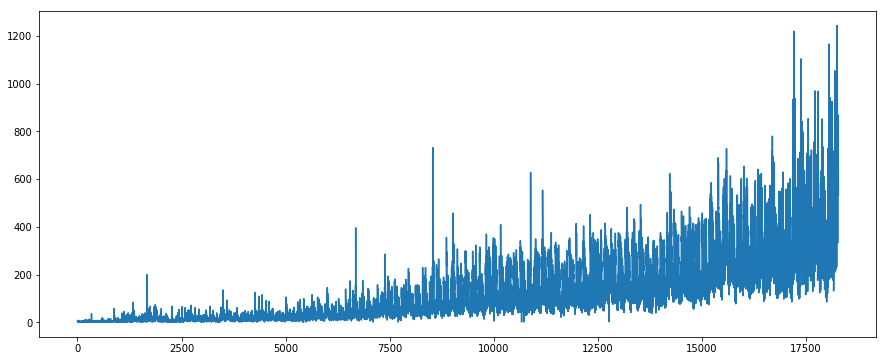

In [29]:
fig = plt.figure()
fig.set_size_inches(15,6)
plt.plot(train.Count, label = 'Count')
plt.show()

In [23]:
train.index = train.Datetime

In [7]:

monthly = train.resample('M').mean()
weekly = train.resample('W').mean()
dayly = train.resample('D').mean()
hourly = train.resample('H').mean()

fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
dayly.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

## train and validation splitting
## We split last three months and use it a as our validation data


In [36]:
Train=train[0:16032]
valid=train[16032:18289]

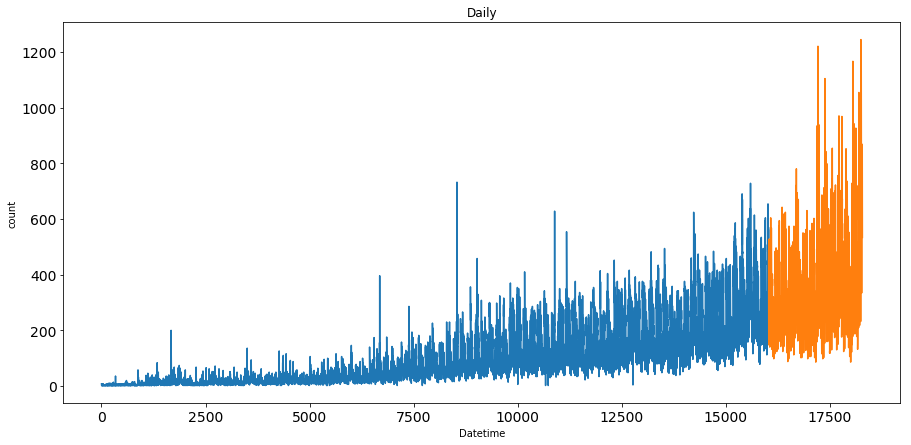

In [40]:
Train.Count.plot(figsize=(15,7), title= 'Daily', fontsize=14, label='train')
valid.Count.plot(figsize=(15,7), title= 'Daily', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("count")
plt.show()

# MODELS
## 1. Naive approach

In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction. 

In [47]:
list(train['Count'])[-1]

534

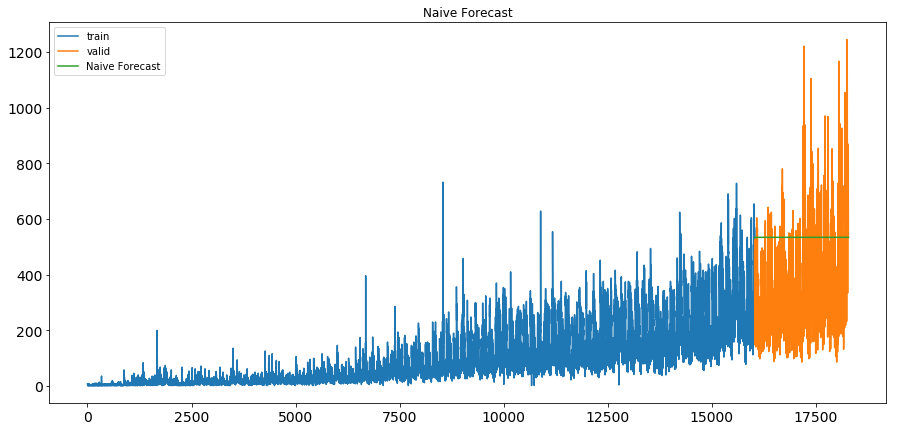

In [48]:
y_pred = valid.copy()
y_pred['naive'] = list(train['Count'])[-1]
plt.figure(figsize = (15,7))

Train.Count.plot(figsize=(15,7), title= 'Daily', fontsize=14, label='train')
valid.Count.plot(figsize=(15,7), title= 'Daily', fontsize=14, label='valid')
plt.plot(y_pred.index, y_pred['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_pred.naive)) 
print(rms)

235.5866526821624


## 2. Moving Average

In this technique we will take the average of the passenger counts for last few time periods only.

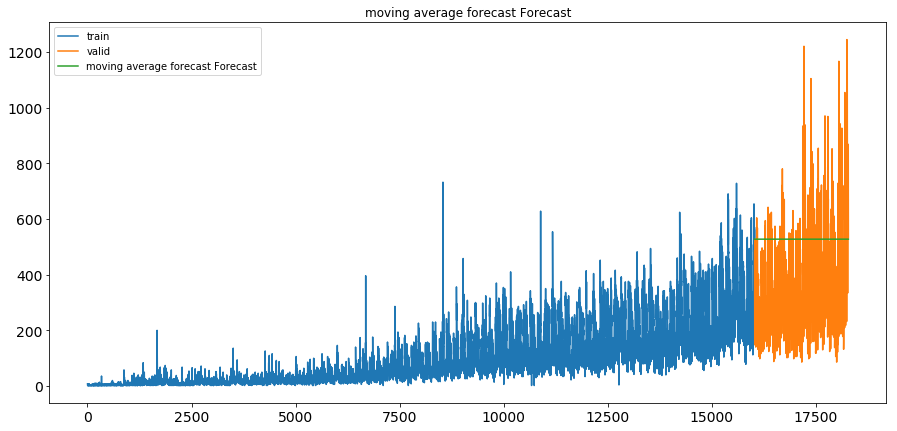

In [50]:
y_pred['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1]

plt.figure(figsize = (15,7))

Train.Count.plot( title= 'Daily', fontsize=14, label='train')
valid.Count.plot( title= 'Daily', fontsize=14, label='valid')
plt.plot(y_pred.index, y_pred['moving_avg_forecast'], label='moving average forecast Forecast') 
plt.legend(loc='best') 
plt.title("moving average forecast Forecast") 
plt.show()

In [51]:
rms = sqrt(mean_squared_error(valid.Count, y_pred.moving_avg_forecast)) 
print(rms)

231.586115288301


## 3. Simple Exponential Moving Average

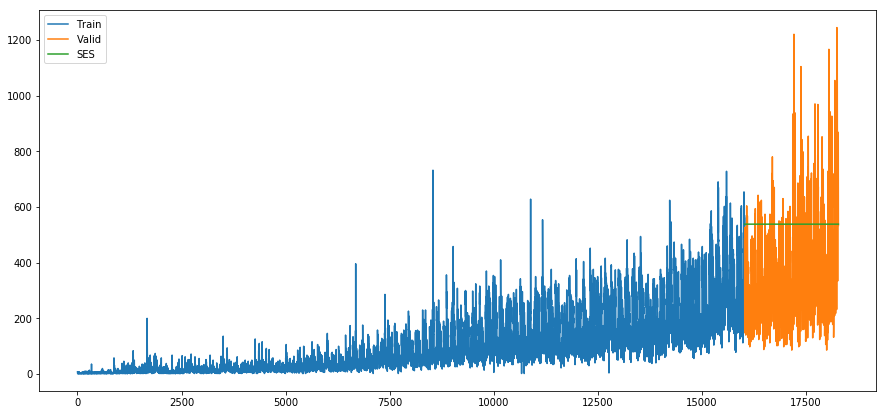

In [52]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.8,optimized=False) 
y_pred['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(15,7)) 
Train.Count.plot(label='Train') 
valid.Count.plot(label='Valid') 
plt.plot(y_pred['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [53]:
rms = sqrt(mean_squared_error(valid.Count, y_pred.naive)) 
print(rms)

235.5866526821624


## 4. Holt's Linear trend model

It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.


First of all let us visualize the trend, seasonality and error in the series.

We can decompose the time series in four parts.

Observed, which is the original time series.
Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
Seasonal, which tells us about the seasonality in the time series.
Residual, which is obtained by removing any trend or seasonality in the time series.
Lets visualize all these parts.

<Figure size 432x288 with 0 Axes>

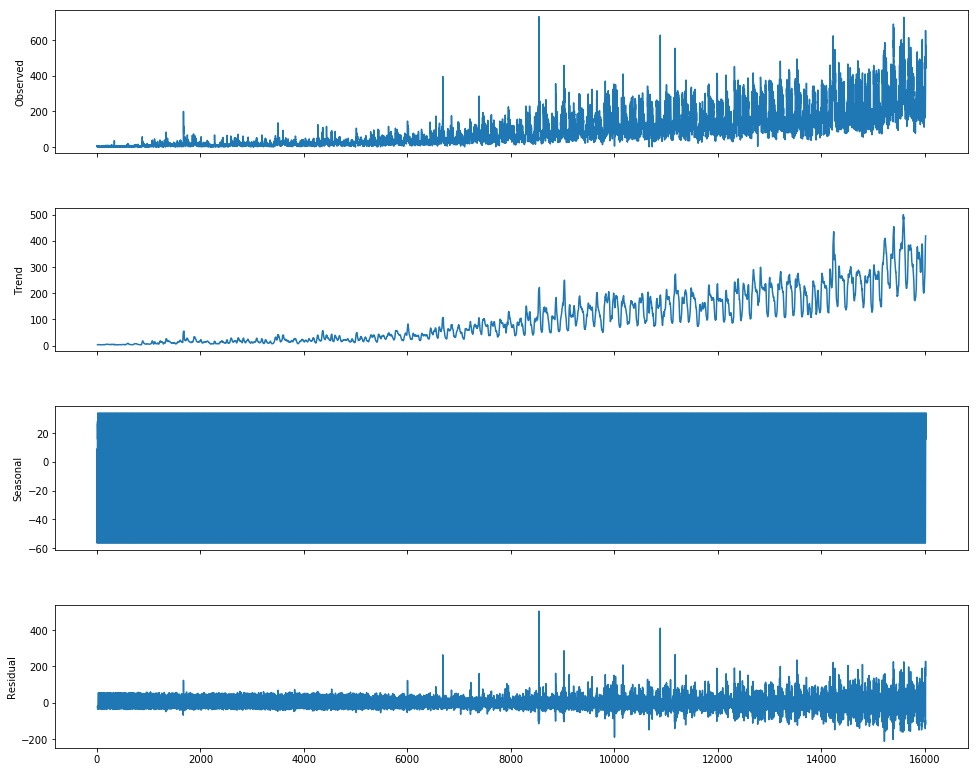

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(Train.Count, model = 'additive', freq =24)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)
plt.show()

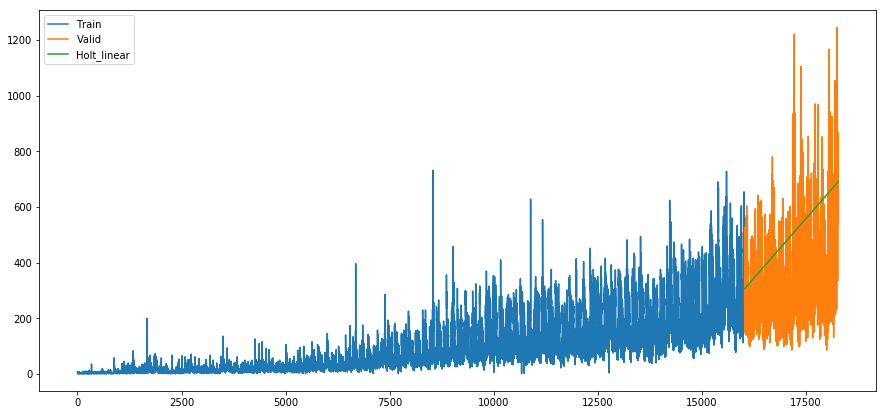

In [60]:
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.01,smoothing_slope = 0.01) 

y_pred = valid.copy()
y_pred['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(15,7)) 
Train.Count.plot(label='Train') 
valid.Count.plot(label='Valid') 
plt.plot(y_pred['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [61]:
rms = sqrt(mean_squared_error(valid.Count, y_pred.Holt_linear)) 
print(rms)

214.9930606210806


# 5. Arima model
### ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

Here p is the order of the autoregressive model(number of time lags)
d is the degree of differencing(number of times the data have had past values subtracted)
q is the order of moving average model. We will discuss more about these parameters in next section.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

## What is a stationary time series?
### There are three basic criterion for a series to be classified as stationary series :

The mean of the time series should not be a function of time. It should be constant.
The variance of the time series should not be a function of time.
THe covariance of the ith term and the (i+m)th term should not be a function of time.

### Why do we have to make the time series stationary?
We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.
If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data.

First of all we have to make sure that the time series is stationary. If the series is not stationary, we will make it stationary.

## Stationarity Check

We use Dickey Fuller test to check the stationarity of the series.
The intuition behind this test is that it determines how strongly a time series is defined by a trend.
The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

In [62]:
def test_stationarity(timeseries, window = 24, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(18, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

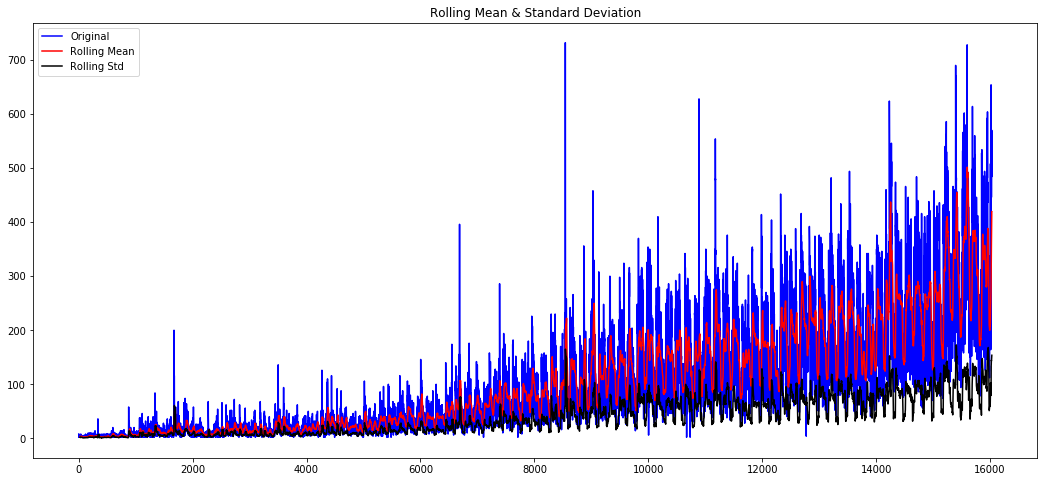

Results of Dickey-Fuller Test:
p-value = 0.0012. The series is likely stationary.
Test Statistic                    -4.054382
p-value                            0.001151
#Lags Used                        20.000000
Number of Observations Used    16011.000000
Critical Value (1%)               -3.430758
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [64]:
test_stationarity(Train['Count'])

## Removing Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

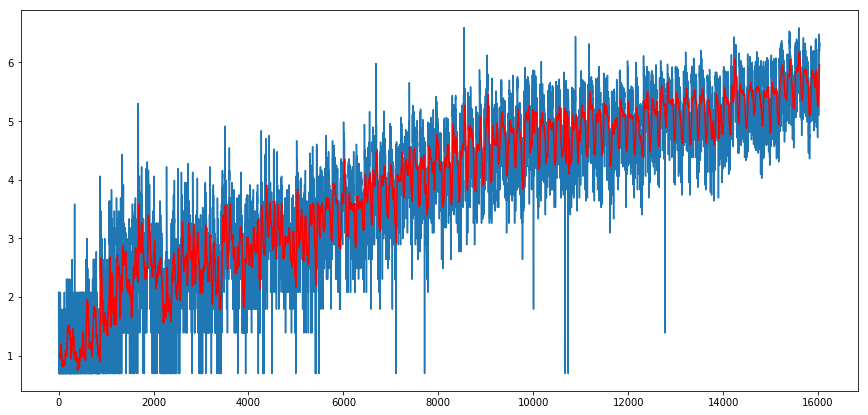

In [68]:
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean() 
plt.figure(figsize=(15,7)) 
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [69]:
train_log_moving_avg_diff = Train_log - moving_avg


Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

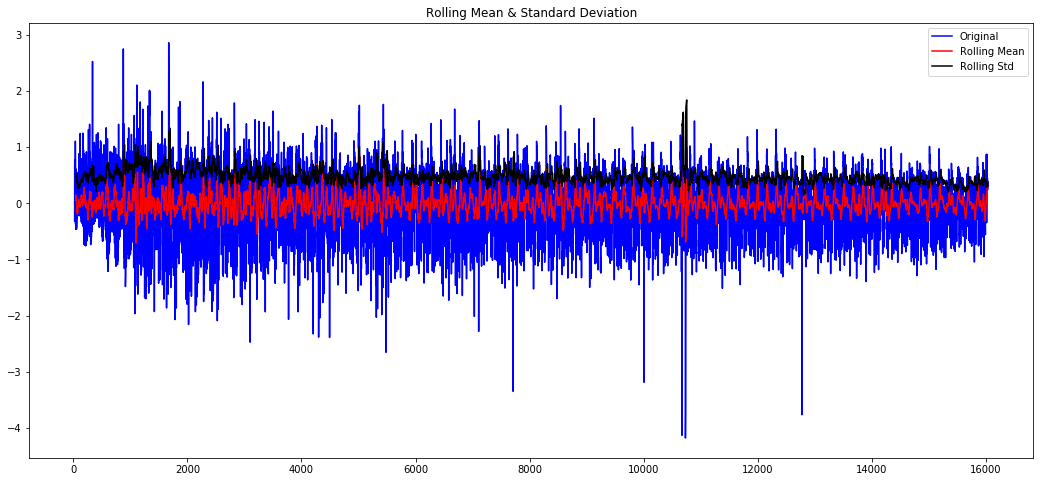

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -22.803732
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    15988.000000
Critical Value (1%)               -3.430759
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [70]:
train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

Differencing can help to make the series stable and eliminate the trend.

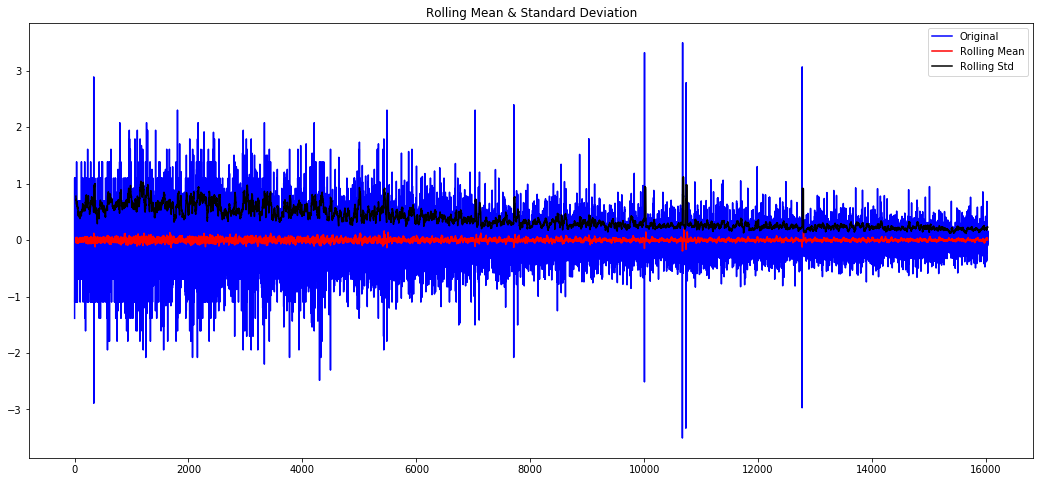

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -62.537405
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    16010.000000
Critical Value (1%)               -3.430759
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [71]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

## Now our series is almost stationary

## Forecasting the time series using ARIMA
First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

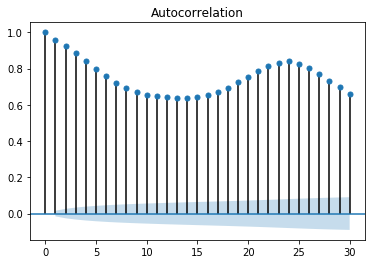

In [79]:
plot_acf(Train['Count'], lags = 30)
plt.show()

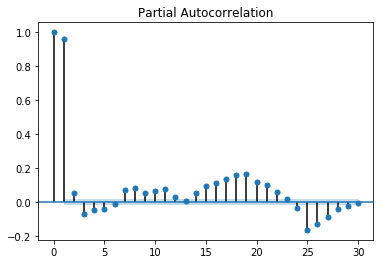

In [80]:
plot_pacf(Train['Count'], lags = 30)
plt.show()

* p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.
* q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.


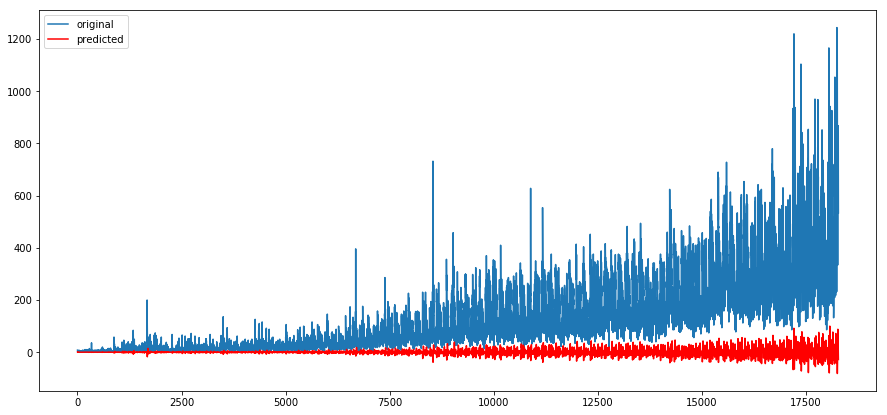

In [99]:
model = ARIMA(train.Count, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1) 
plt.figure(figsize = (15,7))
plt.plot(train.Count,  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()


In [208]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * list(np.log(given_set['Count']))[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.log(predict_log)

    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

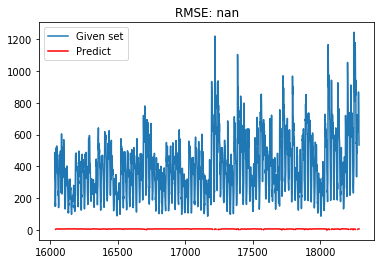

In [209]:
ARIMA_predict_diff=results_ARIMA.predict(start= 16032, end= 18287)
check_prediction_diff(ARIMA_predict_diff, valid)

In [193]:
predict_diff= predict_diff.cumsum().shift().fillna(0)
predict_base = pd.Series(np.ones(given_set.shape[0]) * list(np.log(given_set['Count']))[0], index = given_set.index)
predict_log = predict_base.add(predict_diff,fill_value=0)
predict = np.exp(predict_log)

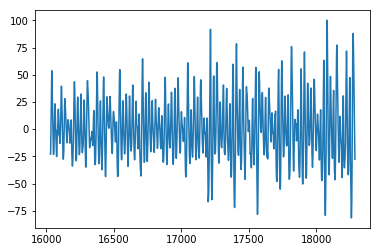

In [203]:
plt.plot(ARIMA_predict_)

In [6]:
# We cannot seperate time series randomly because we have to maintain the sequence to time stamps. Becuase we have to predict
# fureter time counts. 
# split into train and test sets
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
model = Sequential()
dataframe = pd.read_csv('time.csv', usecols=[2], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

Using TensorFlow backend.



12250 6035


In [213]:
import numpy
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.asarray(dataX), numpy.asarray(dataY)

In [214]:

from sklearn.preprocessing import MinMaxScaler
look_back=1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



In [215]:

model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=1)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
12248/12248 [==============================] - 28s 2ms/step - loss: 6.7729e-04
Epoch 2/5
12248/12248 [==============================] - 25s 2ms/step - loss: 5.6760e-04
Epoch 3/5
12248/12248 [==============================] - 26s 2ms/step - loss: 5.7259e-04
Epoch 4/5
12248/12248 [==============================] - 25s 2ms/step - loss: 5.4665e-04
Epoch 5/5
12248/12248 [==============================] - 27s 2ms/step - loss: 5.4551e-04


In [216]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25.26 RMSE
Test Score: 90.40 RMSE


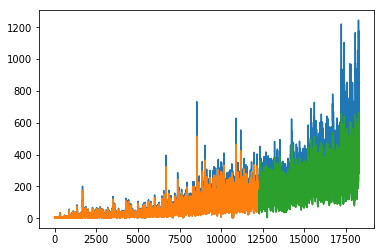

In [217]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()